In [1]:
# Function for importing and parsing Quantius results
from QuantiusResult import importAnnotations

# Modules for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Modules for clustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

%matplotlib inline

# Objective
This notebook explores the analysis of crowd-sourced annotation of RNA FISH data.

# Data set
The annotated image is a crop of an image of GAPDH RNA detected via padlock probes and amplified with rolling circle amplification. The images were acquired on a widefield epifluorescence microscope with a 20x 0.80 NA dry objective (pixels are 325 x 325 nm^2 in the sample plane). The image was annotated by 20 people on Mechanical Turk via Quantius. The data are imported via the function importAnnotations() into a Pandas DataFrame with the following columns:

annotation DataFrame columns (each row is an annotation):
* timestamp - this is a timestamp for the annotation, but I am unsure of the units - need to discuss with Quantius
* x - the x-coordinate of the annotation
* y - the y-coordinate of the annotation
* annotation_type - the type of annotation that was requested. "crosshair" is used for point selection.
* height - height of the image in pixels
* width - width of the image in pixels
* image_filename - filename of the image that was annotated
* time_when_completed - time when the worker finished annotating the image
* worker_id - unique identifier for the worker that performed the annotation

Note that for the coordinates, the origin (0, 0) is in the upper left hand corner of the image with +x to the right and +y down.

In [2]:
anno = importAnnotations('Cy3.json')

In [5]:
coords = anno.loc[:, ['x', 'y']].as_matrix()

af = AffinityPropagation(preference=-100).fit(coords)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

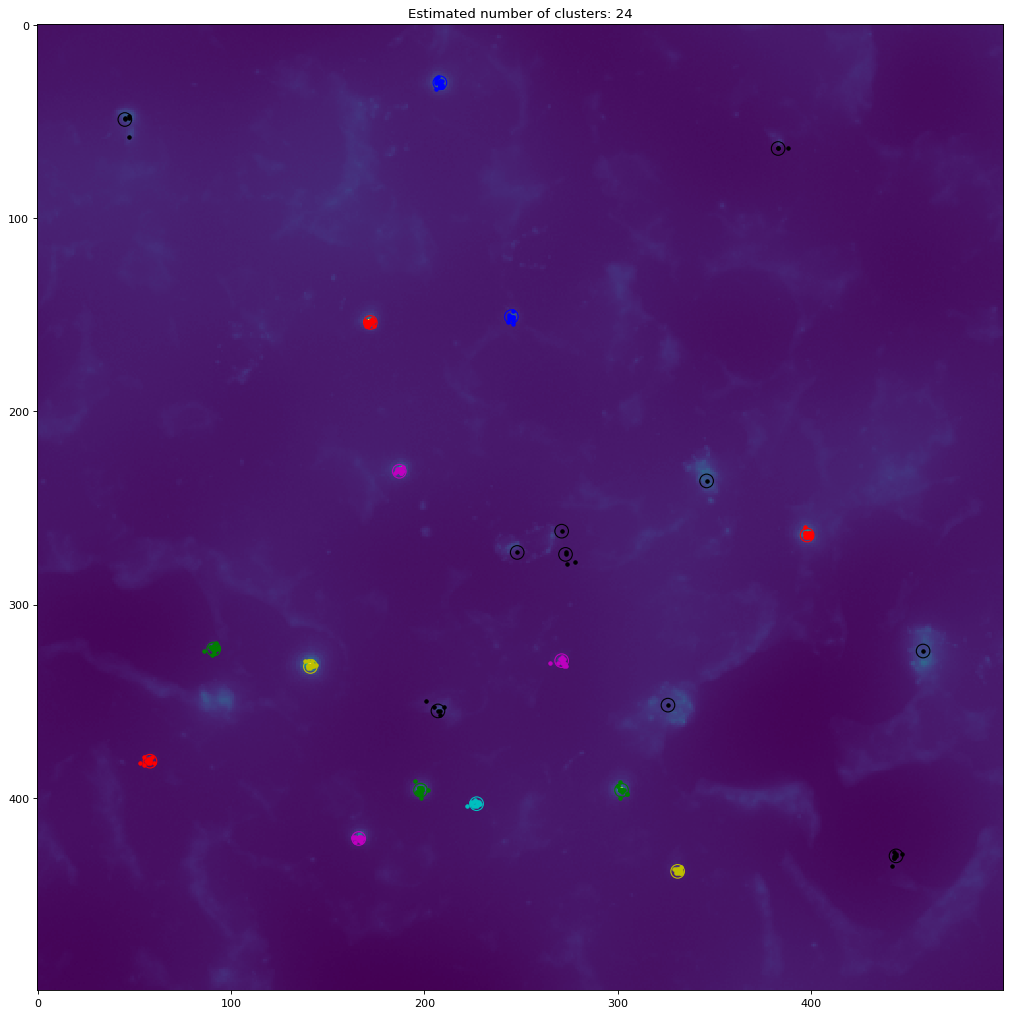

In [6]:
# Plot result
from itertools import cycle

fig=plt.figure(figsize=(18, 16), dpi= 80)

img = mpimg.imread('./crops/cy3_500pxroi.png')
imgplot = plt.imshow(img)

colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    
    if sum(class_members) < 10:
        col = 'k'
    
    cluster_center = coords[cluster_centers_indices[k]]
    plt.plot(coords[class_members, 0], 500 - coords[class_members, 1], col + '.')
    plt.scatter(cluster_center[0], 500 - cluster_center[1], facecolors='none', edgecolor = col, s = 150)
    #for x in coords[class_members]:
    #    plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

(0, 20)

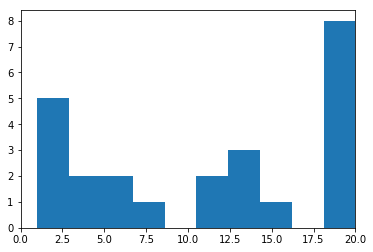

In [13]:
n_class_members = []

for i in range(n_clusters_):
    class_members = labels == i
    n_class_members.append(sum(class_members))
    
plt.hist(n_class_members, 10)
plt.xlim((0, 20))

In [14]:
import numpy as np

# Test the sensitivity of the "preference" parameter

n_clusters = []
prefs = []

for pref in np.arange(-200, 0):
    af = AffinityPropagation(preference=pref).fit(coords)
    cluster_centers_indices = af.cluster_centers_indices_
    
    n_clusters.append(len(cluster_centers_indices))
    prefs.append(pref)
    

Text(0,0.5,'Number of clusters')

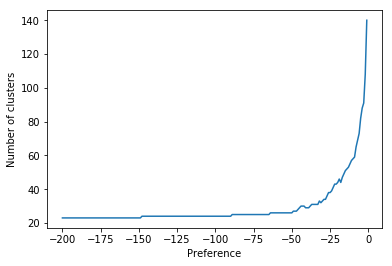

In [15]:
plt.plot(prefs, n_clusters)
plt.xlabel('Preference')
plt.ylabel('Number of clusters')

In [16]:
# Resample
pref = -100

# Get the number of workers and worker IDs
worker_ids = anno.worker_id.unique()
total_turkers = len(worker_ids)

n_clusters = []
n_samples = []

for n_turkers in np.arange(1, 20):
        
    n_clust_subsample = []
    
    for i in range(50):
        # Get the subsampled data
        indices = np.random.choice(total_turkers, n_turkers, replace=False)
        
        worker_subsample= worker_ids[indices]
        
        coords = anno.loc[anno['worker_id'].isin(worker_subsample), ['x', 'y']]
        
        # Calculate the number of clusters
        af = AffinityPropagation(preference=pref).fit(coords)
        cluster_centers_indices = af.cluster_centers_indices_
    
        n_clust_subsample.append(len(cluster_centers_indices))

    
    # Save the data to the lists
    n_clusters.append(n_clust_subsample)
    n_samples.append(n_turkers)


Text(0,0.5,'Number of clusters')

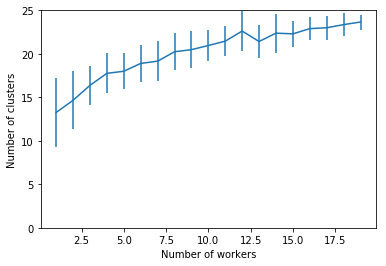

In [18]:
# Plot the subsampling results

means = np.mean(n_clusters, axis = 1)
stds = np.std(n_clusters, axis = 1)


plt.errorbar(n_samples, means, yerr = stds)
#plt.plot(n_samples, means, 'k-')
#plt.fill_between(n_samples, means-stds, means+stds, alpha=0.5, edgecolor=None)

plt.ylim((0, 25))
plt.xlabel('Number of workers')
plt.ylabel('Number of clusters')
    

Text(0,0.5,'Coefficient of variation [%]')

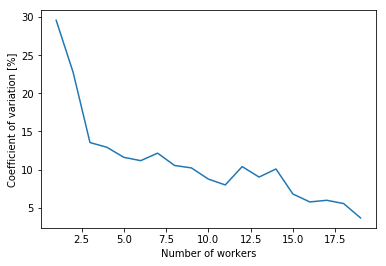

In [19]:
plt.plot(n_samples, stds / means * 100)
plt.xlabel('Number of workers')
plt.ylabel('Coefficient of variation [%]')